![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

<a href='#2' > DATA
    
<a href='#3' > Exploratory data analysis (EDA)

# import

In [149]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer # Для кодирования Cuisine Style в dummy-переменные


# Инструмены для ML и расчета MAE
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [150]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [151]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Создание класса

In [177]:
class TadRating():
    ''' FIXME '''
    
    def __init__(self, dataframe):
        self.dat = dataframe
        
        
        
    
    def per_none(self):
        ''' 
        Метод который считает процент пропусков в датасете 
        и рисует график распределения пропусков (Название столбца - процент пропусков)
        '''
        # Считаем процент пропусков
        per_of_skips = pd.DataFrame(1-self.dat.count()/self.dat.shape[0]).reset_index().rename({0: 'percent'}, axis=1)
        per_of_skips = per_of_skips.sort_values('percent', ascending=False).query('percent>0')

        # Визуализация пропусков
        fig, ax = plt.subplots(figsize = (12, 8))
        bar_plot = sns.barplot(x='percent', y='index', data=per_of_skips, alpha=0.8, ci=None)
        for ytick in bar_plot.get_yticks():
            if per_of_skips.iloc[ytick][1]>0:
                bar_plot.text(per_of_skips.iloc[ytick][1]+0.0125, ytick, str(round(per_of_skips.iloc[ytick][1]*100,2))+' %', 
                    horizontalalignment='center',size=10, color='black', weight='semibold')
        plt.title('Относительное количество пропусков')
        plt.gca().set_xlabel('Процент', fontsize=12)
        plt.gca().set_ylabel('Название колонки', fontsize=12)
        plt.show()
        
        
    def city_info(self):
        ''' 
        Метод показывающий информацию по колонке City.
        Выводит информацию обуникальных городах, количество ресторанов по городам
        '''
        
        print(self.dat['City'].value_counts(ascending=False))
        print('##########################################')
        print('Всего городов в датасете представлено - {}'.format(len(self.dat['City'].value_counts(ascending=True))))
        print('##########################################')
        # График 
        plt.rcParams['figure.figsize'] = (10, 10)
        self.dat['City'].value_counts(ascending=True).plot(kind='barh')
        plt.gca().set_xlabel('Количество ресторанов', fontsize=18)
        plt.gca().set_ylabel('Город', fontsize=18)
        plt.title("Распределение количества ресторанов по городам", fontsize=20)
        plt.grid(linestyle='--', alpha=0.7)
        
        
        
    def draw_bp(self, column):
        ''' 
        Метод для отрисовки боклсплота для конкретного признака
        по целевой переменной Rating.
        '''

        fig, ax = plt.subplots(figsize=(25, 5))
        sns.boxplot(x=column, y='Rating', data=self.dat, ax=ax)
        ax.set_title('Боксплот для ' + column)
        plt.show()
        
    def cuisine_info(self):
        
        ''' 
        Метод показывающий информацию по колонке Cuisine Style.
        Выводит информацию о видах кухни представленых их количестве
        Неизвестные кухни заменяет на Unknown        
        
        '''
        
            
        def clean_name(str_val):
 
            '''
            Преобразует строку с названиями кухонь в список [list] названий кухонь.
            На входе:
                - строковая переменная, содержащая названия кухонь.
            На выходе:
                - список [list] названий кухонь.
            '''
            if pd.isna(str_val): return ["Unknown"]
            str_val = str_val.strip('[]') # Отбрасываем скобки.
            str_val = str_val.replace("\'",'') # Убираем кавычки '.
            str_val = str_val.split(", ") # Разбиваем строку по названиям кухонь.
            return str_val
        
        print(self.dat['Cuisine Style'].describe())
        print('##########################################')
        print('Пустых значений - {}'.format(self.dat['Cuisine Style'].isna().value_counts().min()))
        print('##########################################')
        
        
        self.dat['Cuisine Style'] = self.dat['Cuisine Style'].apply(clean_name)
        dft = self.dat['Cuisine Style'].explode() # Для подсчета всех кухонь в датасете
        print ('Всего в датасете представлено {} кухонь'.format(len(dft.value_counts())-1))      
        print ('##########################################')
        print ('Пустые значения переименованы в "Unknown"\n','##### Топ типов кухонь в ресторанах ###### \n',dft.value_counts(), sep='')
        
    def cuisine_fill_null(self):
        '''
        Метод заменяет неизвестные значия кухонь на список "European" и "Vegetarian Friendly"
        '''
        self.dat['Cuisine Style'] = self.dat.loc[:, ('Cuisine Style')].apply(lambda x: ['European', 'Vegetarian Friendly'] 
                                                                   if x == ['Unknown'] else x)
        print(self.dat.info())
        
    def praice_range_info(self):
        ''' 
        Метод показывает информацию о колонке Price Range
        '''
        pass

In [179]:
dir(TadRating)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'city_info',
 'cuisine_fill_null',
 'cuisine_info',
 'draw_bp',
 'per_none',
 'praice_range_info']

<a id='2'> </a>
# DATA

In [153]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [154]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [155]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [156]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [157]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [158]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [159]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [160]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [161]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [162]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
2797,id_2797,Amsterdam,"['Dutch', 'European', 'Grill', 'Central Europe...",179.0,$,155.0,"[['A great find!', 'Really good find with good...",/Restaurant_Review-g188590-d10507583-Reviews-P...,d10507583,0,0.0
41694,id_2721,Barcelona,"['Seafood', 'Mediterranean']",2722.0,$$ - $$$,51.0,"[['Paella menu', 'Fresh seafood'], ['05/06/201...",/Restaurant_Review-g187497-d11046186-Reviews-E...,d11046186,1,4.0
14316,id_6368,Madrid,"['Pizza', 'Italian']",6371.0,NaN,68.0,"[['Very good friendly familiar option', 'An up...",/Restaurant_Review-g187514-d717370-Reviews-Piz...,d717370,1,3.0
33321,id_653,Edinburgh,"['Italian', 'Pizza', 'Vegetarian Friendly', 'G...",654.0,$$ - $$$,357.0,"[['Visited by recommendation', 'Nice pizza at ...",/Restaurant_Review-g186525-d1316490-Reviews-Th...,d1316490,1,3.5
6640,id_6640,Stockholm,"['Barbecue', 'European', 'Soups', 'Swedish', '...",1295.0,$$ - $$$,18.0,[['Very Nice location with terrace and good s....,/Restaurant_Review-g189852-d8479516-Reviews-Dj...,d8479516,0,0.0


In [163]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

<a id='3'> </a>
# Exploratory data analysis (EDA)


Проведем первичный анализ данных. Проверка на наличие пропусков и их подсчет. 

Все дополнительные признаки будут создаваться в разделе <a href='#3' > Data Preprocessing

In [164]:
# Создадим экземпляр класса TadTadRating data_w - (data work) рабочий датасет
data_w = TadRating(data)


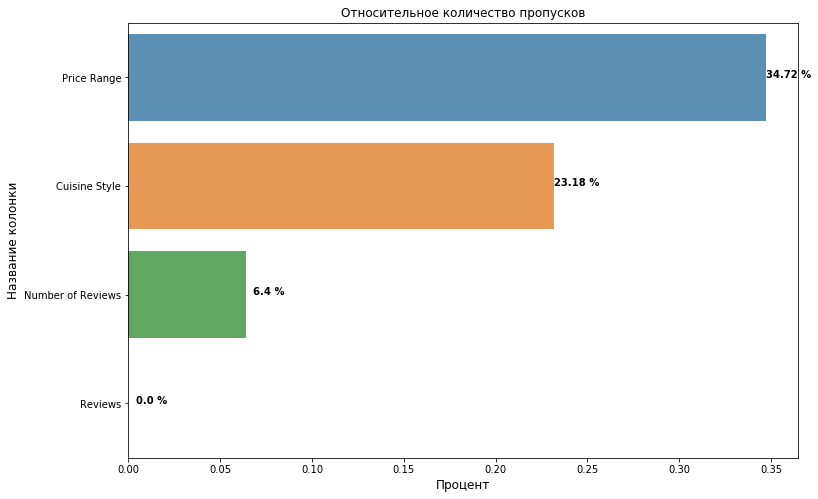

In [165]:
data_w.per_none()

#### Restaurant_id - порядковый номер ресторана

In [166]:
data.loc[:, ['Restaurant_id']].info()
display(data.Restaurant_id.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
Restaurant_id    50000 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


id_871      19
id_227      19
id_633      19
id_436      19
id_534      18
            ..
id_15266     1
id_14498     1
id_12962     1
id_10279     1
id_12354     1
Name: Restaurant_id, Length: 13094, dtype: int64

Нет пропусков но есть повторяющиеся значения - можно сделать вывод что это сеть ресторанов. Можно добавить новый признак является ли ресторан частью сети или нет.

#### City

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64
##########################################
Всего городов в датасете представлено - 31
##########################################


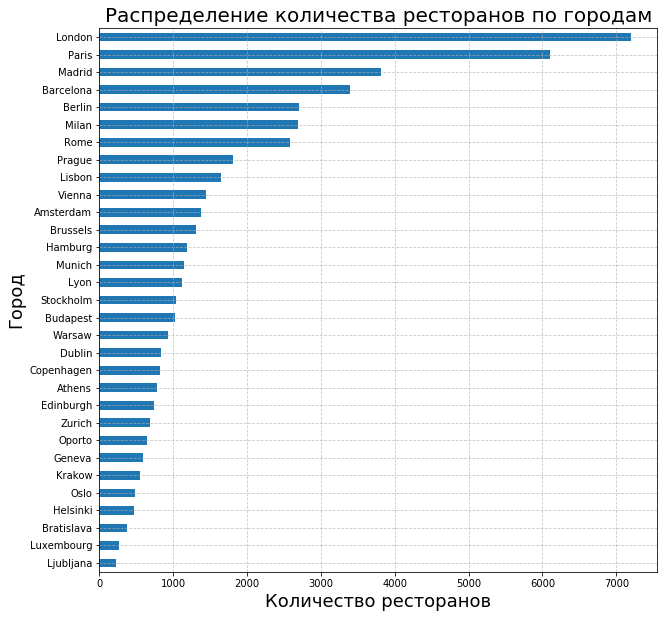

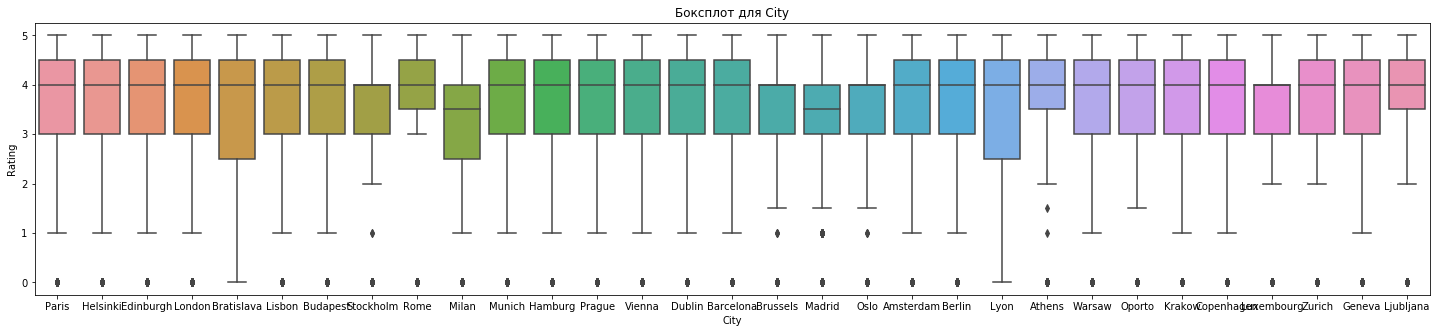

In [167]:
data_w.city_info()
data_w.draw_bp('City')

Пропусков нет. Всего в датасете представлен 31 город. Медиана по рейтингу в городах почти одинаковая. Низкий рейтинг (исключая 0) является допустимым выбросом.

На основе этого признака можно создать дополнительные.  

#### Cousine Style - виды кухни которые предствлены в ресторане

In [168]:
data_w.cuisine_info()

count           38410
unique          10731
top       ['Italian']
freq             1332
Name: Cuisine Style, dtype: object
##########################################
Пустых значений - 11590
##########################################
Всего в датасете представлено 125 кухонь
##########################################
Пустые значения переименованы в "Unknown"
##### Топ типов кухонь в ресторанах ###### 
Vegetarian Friendly    14021
European               12561
Unknown                11590
Mediterranean           7820
Italian                 7433
                       ...  
Polynesian                 2
Salvadoran                 1
Xinjiang                   1
Latvian                    1
Burmese                    1
Name: Cuisine Style, Length: 126, dtype: int64


На основе этого признака создадим дополнительные. Пустые значения заменим на список из 2х самых популярных кухонь  "European" и "Vegetarian Friendly". Более того в датасете седержатся только города Европы и европейская кухня как обощающая подходит идеально. 

In [144]:
data_w.cuisine_fill_null()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        50000 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB
None


In [ ]:
data['cuisine_count'] = data['cuisine_style'].apply(lambda x: len(x))

#### Price Range

In [176]:
display(data['Price Range'].describe())
display(data['Price Range'].explode().value_counts())

count        32639
unique           3
top       $$ - $$$
freq         23041
Name: Price Range, dtype: object

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

есть пропуски - заполним наиболее частным значение, приведем признак к числовому значения через словарь 


In [ ]:
data['Price Range'] = data['Price Range'].fillna('$$ - $$$')
price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}

# выполним преобразование
data['Price Range'].replace(price_dict, inplace=True)

In [ ]:
data['Price Range'].describe()

####  Number of Reviews


In [ ]:
data['Number of Reviews'].isna().value_counts() # есть пропуски - посчитаем медиану и заполним все NA

In [ ]:
median = data['Number of Reviews'].median()
data['Number of Reviews'] = data['Number of Reviews'].apply (lambda x: median if pd.isnull(x) else x)

In [ ]:
data['Number of Reviews'].isna().value_counts()

#### Reviews

#### cuisine_style

рассмотрим уже созданный признак cusin_style и создадим новые признаки этом основании - представим что каждому виду кухни будет соответствовать 1, при отсутствии этого вида кухни 0

In [ ]:
cuisine_style = data['cuisine_style']

In [ ]:
# Поскольку в столбце списки, с начала получаем перечень уникальных значений

cuisines = set()

for row in cuisine_style:
    if type(row) == float:
        continue
    for cuisine in row:
        cuisines.add(cuisine)

# Затем создал столбцы для каждой кухни

def find_item(cell):
    if item in cell:
        return 1
    return 0

for item in cuisines:
    data[item] = data['cuisine_style'].apply(find_item)

In [ ]:
data.head(5)

#### URL_TA и ID_TA

In [ ]:
data['URL_TA'].describe() # предствляет собой страницы ресторанов с трипэдвайзера - в модели учавствовать не будет (хотя интересно что есть повторяющееся значения)

In [ ]:
data['ID_TA'].describe() # предствляет собой ID ресторана на том же самом сайте - в модели учавствовать не будет 

#### Ranking и Number of Reviews (снова)

In [ ]:
#display(data.Ranking.describe()) # пропусков нет - но сами значения достаточно большие - можно сделать STD нормализацию
#display(data['Number of Reviews'].describe) # пропуски уже заполнил - можно сделать сделать STD нормализацию

In [ ]:
#data['City'].info()

### Посмотрим распределение признака

In [ ]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

In [ ]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

In [ ]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

In [ ]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

In [ ]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

In [ ]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

In [ ]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),cmap="BrBG")
data.drop(['sample'], axis=1).corr()

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [ ]:
# на всякий случай, заново подгружаем данные
#df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
#df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
#df_train['sample'] = 1 # помечаем где у нас трейн
#df_test['sample'] = 0 # помечаем где у нас тест
#df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

#data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
#data.info()

In [ ]:
#def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    #df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    #df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    #df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    #df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    #object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    #df_output.drop(object_columns, axis = 1, inplace=True)
    
    #return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [ ]:
#df_preproc = preproc_data(data)
#df_preproc.sample(10)

In [ ]:
#df_preproc.info()

In [ ]:
data.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [ ]:
data.info()

In [ ]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Model 
Сам ML

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission_1.csv', index=False)
sample_submission.head(10)

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
